In [1]:
import pandas as pd 
import numpy as np
import lightgbm as lgb
from lightgbm import log_evaluation
import datetime
import pickle
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
def calculate_lags(df, col, lags, shift=0):
    for l in lags:
        df[f"lag_{col}_{l}"] = df.groupby(["ts_id"])[col].shift(shift + l).astype(np.float16)

def calculate_rollings(df, col, rollings, shift=0):
    for r in rollings:
        df[f"rol_mean_{col}_{r}"] = df.groupby(["ts_id"])[col].shift(shift + 1).rolling(r, min_periods=1).mean()
        df[f"rol_std_{col}_{r}"] = df.groupby(["ts_id"])[col].shift(shift + 1).rolling(r, min_periods=1).std()
        df[f"rol_min_{col}_{r}"] = df.groupby(["ts_id"])[col].shift(shift + 1).rolling(r, min_periods=1).min()
        df[f"rol_max_{col}_{r}"] = df.groupby(["ts_id"])[col].shift(shift + 1).rolling(r, min_periods=1).max()


from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [10]:
path = '/Users/idris/Documents/ds_project/forecast_store_sales/data/'
list_cutoff = ['2017-08-16']

# cutoff = '2017-07-31'
cutoff = '2017-08-16'

col_to_ignore = ["date", "is_future", "forecast_step", "ts_id"]

TARGET_COL = 'sales'

prediction_length = 16
lags_target=list(range(1, 16))
rollings_target=[2, 4, 8, 16]

In [11]:
df_cutoff = pd.read_csv(path + f'fe/cutoff/{cutoff}/final_frame.csv', sep=';').drop('transactions', axis=1)
df_cutoff['date'] = pd.to_datetime(df_cutoff['date'])
df_cutoff['is_future'] = df_cutoff['is_future'].fillna(False)
df_cutoff["time_idx"] = ((df_cutoff["date"] - df_cutoff["date"].min()).dt.days).astype(int)

df_cv = df_cutoff.loc[df_cutoff["is_future"] == False].reset_index(drop=True)

clean = pd.read_csv(path + f'trainclean.csv', sep=';')
clean['date'] = pd.to_datetime(clean['date'])

In [12]:
df_cutoff[df_cutoff['ts_id'] == '9_28'][['ts_id', 'date', 'time_idx', 'is_future']].sort_values('date', ascending=True).head()

,ts_id,date,time_idx,is_future
2442795,9_28,2013-01-02,1,False
2442796,9_28,2013-01-03,2,False
2442797,9_28,2013-01-04,3,False
2442798,9_28,2013-01-05,4,False
2442799,9_28,2013-01-06,5,False


In [13]:
df_cv['time_idx'].describe().astype(int)

count    2450500
mean         925
std          466
min            0
25%          547
50%          955
75%         1327
max         1687
Name: time_idx, dtype: int64

In [17]:
for train_idx, test_idx in GroupTimeSeriesSplit(n_splits=5).split(df_cv, groups=df_cv['time_idx']):
    i_train = df_cv.loc[train_idx, 'time_idx'].unique()
    train = df_cv.loc[df_cv['time_idx'].isin(i_train)]
    print(train['time_idx'].unique())
    print(train['time_idx'].nunique())
    
    i_test = df_cv.loc[test_idx, 'time_idx'].unique()[:16]
    test = df_cv.loc[df_cv['time_idx'].isin(i_test)]
    print(test['time_idx'].unique())
    print(test['time_idx'].nunique())
    

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

In [244]:
params = {
        'boosting_type': 'gbdt',
        'objective': 'tweedie',
        'tweedie_variance_power': 1.1,
        'metric': 'rmse',
        'max_bin': 100,
        'subsample': 0.5,
        'subsample_freq': 1,
        'learning_rate': 0.015,
        'num_leaves': 2**11-1,
        'min_data_in_leaf': 2**12-1,
        'feature_fraction': 0.5,
        'n_estimators': 300,
        'boost_from_average': False, 
        'verbose': -1
                } 

In [236]:
params = {
        'boosting_type': 'gbdt',
        'objective': 'tweedie',
        'tweedie_variance_power': 1.1,
        'metric': 'rmse',
        'max_bin': 100,
        'subsample': 0.5,
        'subsample_freq': 1,
        'learning_rate': 0.015,
        'num_leaves': 2**11-1,
        'min_data_in_leaf': 2**12-1,
        'feature_fraction': 0.5,
        'n_estimators': 1300,
        'boost_from_average': False,
        'verbose': -1
                } 

In [9]:
params = {
    "objective": "tweedie",
    'tweedie_variance_power': 1.4000000000000001,
    'n_estimators': 500,
    'learning_rate': 0.067307721852165,
    'num_leaves': 300,
    'max_depth': 10,
    'min_data_in_leaf': 1300,
    'lambda_l1': 100,
    'lambda_l2': 80,
    'min_gain_to_split': 9.72024574054834,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'feature_fraction': 0.6000000000000001,
    "random_state": 1990,
    "metric": "rmse",
    "verbose": -1
}

In [17]:
# Tuned
params = {
    "boosting_type": "gbdt", 
    "num_leaves": 2**8-1,
    "max_depth": -1, 
    "learning_rate": 0.015,
    "n_estimators": 1000, #100
    "subsample_for_bin": 200000, 
    "objective": "tweedie", #None
    "tweedie_variance_power": 1.1,
    "class_weight": None, 
    "min_split_gain": 0.0, 
    "min_child_weight": 0.001, 
    "min_child_samples": 20, 
    "subsample": 0.35,
    "subsample_freq": 10,
    "colsample_bytree": 1.0, 
    "reg_alpha": 0.0, 
    "reg_lambda": 0.0, 
    "random_state": 666, 
    "n_jobs": -1, 
    "metric": "rmse",
    'min_data_in_leaf': 2**8-1,
    'feature_fraction': 0.35,
}

In [20]:
params = {
    "objective": "tweedie",
    "tweedie_variance_power": 1.3,
    "n_estimators": 2000,
    "learning_rate": 0.08064028714756555,
    "num_leaves": 2140,
    "max_depth": 12,
    "min_data_in_leaf": 200,
    "lambda_l1": 10,
    "lambda_l2": 55,
    "min_gain_to_split": 7.674179670757204,
    "bagging_fraction": 0.7,
    "bagging_freq": 1,
    "feature_fraction": 0.9,
    "random_state": 1990,
    "metric": "rmse",
    "verbose": -1
    }

In [25]:
params = {
    "boosting_type": "gbdt", 
    "objective": "tweedie",
    "tweedie_variance_power": 1.3,
    "n_estimators": 2000,
    "learning_rate": 0.08064028714756555,
    "num_leaves": 2140,
    "max_depth": 12,
    "min_data_in_leaf": 200,
    "lambda_l1": 10,
    "lambda_l2": 55,
    "min_gain_to_split": 7.674179670757204,
    "bagging_fraction": 0.7,
    "bagging_freq": 1,
    "feature_fraction": 0.9,
    "random_state": 1990,
    "metric": "rmse",
    "verbose": -1
    }

 tweedie_variance_power: 1.3
    n_estimators: 2000
    learning_rate: 0.08064028714756555
    num_leaves: 2140
    max_depth: 12
    min_data_in_leaf: 200
    lambda_l1: 10
    lambda_l2: 55
    min_gain_to_split: 7.674179670757204
    bagging_fraction: 0.7
    bagging_freq: 1
    feature_fraction: 0.9
    
    

In [26]:
list_wape = []
for train_idx, test_idx in tqdm(GroupTimeSeriesSplit().split(df_cv, groups=df_cv['time_idx'])):
    
    i_train = df_cv.loc[train_idx, 'time_idx'].unique()
    df_train = df_cv.loc[df_cv['time_idx'].isin(i_train)].drop(columns=col_to_ignore)
    i_test = df_cv.loc[test_idx, 'time_idx'].unique()[:16]
    df_test = df_cv.loc[df_cv['time_idx'].isin(i_test)].drop(columns=col_to_ignore).drop(columns=TARGET_COL) 
    
    min_train_idx = df_test['time_idx'].min() - prediction_length
    max_train_idx = df_test['time_idx'].max()
    cutoff_idx = np.arange(min_train_idx, max_train_idx + 1, 1)
    df_rec = df_cv.loc[df_cv['time_idx'].isin(cutoff_idx)]    
    
    df_rec.loc[df_rec['time_idx'].isin(i_test), 'is_future'] = True
    df_rec.loc[df_rec["is_future"] == True, "sales"] = np.nan
    
    print('id time to pred', i_test)
    
    train_ds = lgb.Dataset(
    data=df_train.drop(columns=TARGET_COL), 
    label=df_train[TARGET_COL]
    )
    
    gbm = lgb.train(
    params=params,
    train_set=train_ds,
    valid_sets=train_ds,
    callbacks=[log_evaluation(period=100)]
    )
    

    first_future_time_idx = i_test.min()
    df_rec.loc[:, "forecast_step"] = df_rec.loc[:, "time_idx"] - first_future_time_idx + 1 
        
    for fs in range(1, prediction_length + 1):
        
        # predict one step
        df_predict = df_rec.loc[df_rec["forecast_step"] == fs].drop(columns=col_to_ignore + [TARGET_COL])
        predictions = np.clip(gbm.predict(df_predict), a_min=0, a_max=None)

        # update sales_quantity usings predictions
        df_rec.loc[df_rec["forecast_step"] == fs, "sales"] = predictions

        # update target lags & rollings
        calculate_lags(df_rec, TARGET_COL, lags_target)
        calculate_rollings(df_rec, TARGET_COL, rollings_target)
    
    df_forecast = df_rec.loc[df_rec["is_future"] == True, ["ts_id", "date", "sales"]]
    df_forecast["forecast"] = df_forecast["sales"].round(0).astype(int)
    df_forecast.drop(columns="sales", inplace=True)
    
    df_error = pd.merge(df_forecast, clean[['ts_id', 'date', 'sales']], how="left", on=['ts_id', 'date'])
    wape = np.round(np.sum(np.abs(df_error["sales"] - df_error["forecast"])) / np.sum(df_error["sales"]), 3)
    print('wape: ', wape)
    list_wape.append(wape)
    
print('    mean wape: ', np.mean(list_wape)) 

0it [00:00, ?it/s]

id time to pred [284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299]
[100]	training's rmse: 135.808
[200]	training's rmse: 123.536
[300]	training's rmse: 121.019
[400]	training's rmse: 119.855
[500]	training's rmse: 119.029
[600]	training's rmse: 118.411
[700]	training's rmse: 117.937
[800]	training's rmse: 117.558
[900]	training's rmse: 117.136
[1000]	training's rmse: 116.716
[1100]	training's rmse: 116.373
[1200]	training's rmse: 116.115
[1300]	training's rmse: 115.845
[1400]	training's rmse: 115.479
[1500]	training's rmse: 115.269
[1600]	training's rmse: 115.136
[1700]	training's rmse: 114.927
[1800]	training's rmse: 114.773
[1900]	training's rmse: 114.617
[2000]	training's rmse: 114.364


1it [00:55, 55.51s/it]

wape:  0.208
id time to pred [565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580]
[100]	training's rmse: 158.921
[200]	training's rmse: 138.091
[300]	training's rmse: 129.058
[400]	training's rmse: 124.359
[500]	training's rmse: 121.489
[600]	training's rmse: 119.32
[700]	training's rmse: 117.765
[800]	training's rmse: 116.567
[900]	training's rmse: 115.538
[1000]	training's rmse: 114.592
[1100]	training's rmse: 113.734
[1200]	training's rmse: 113.257
[1300]	training's rmse: 112.818
[1400]	training's rmse: 112.267
[1500]	training's rmse: 111.82
[1600]	training's rmse: 111.538
[1700]	training's rmse: 111.041
[1800]	training's rmse: 110.67
[1900]	training's rmse: 110.464
[2000]	training's rmse: 110.141


2it [02:47, 89.01s/it]

wape:  0.15
id time to pred [846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861]
[100]	training's rmse: 166.294
[200]	training's rmse: 145.804
[300]	training's rmse: 135.377
[400]	training's rmse: 129.541
[500]	training's rmse: 125.388
[600]	training's rmse: 122.265
[700]	training's rmse: 120.397
[800]	training's rmse: 118.625
[900]	training's rmse: 117.238
[1000]	training's rmse: 116.317
[1100]	training's rmse: 115.69
[1200]	training's rmse: 114.981
[1300]	training's rmse: 114.331
[1400]	training's rmse: 113.795
[1500]	training's rmse: 113.184
[1600]	training's rmse: 112.871
[1700]	training's rmse: 112.45
[1800]	training's rmse: 112.112
[1900]	training's rmse: 111.716
[2000]	training's rmse: 111.353


3it [05:55, 133.77s/it]

wape:  0.155
id time to pred [1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139 1140
 1141 1142]
[100]	training's rmse: 176.164
[200]	training's rmse: 153.569
[300]	training's rmse: 143.7
[400]	training's rmse: 136.563
[500]	training's rmse: 131.896
[600]	training's rmse: 128.515
[700]	training's rmse: 126.437
[800]	training's rmse: 124.478
[900]	training's rmse: 123.044
[1000]	training's rmse: 122.032
[1100]	training's rmse: 121.226
[1200]	training's rmse: 120.443
[1300]	training's rmse: 119.619
[1400]	training's rmse: 119.098
[1500]	training's rmse: 118.465
[1600]	training's rmse: 117.969
[1700]	training's rmse: 117.374
[1800]	training's rmse: 116.874
[1900]	training's rmse: 116.452
[2000]	training's rmse: 116.105


4it [26:38, 571.83s/it]

wape:  0.185
id time to pred [1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420 1421
 1422 1423]
[100]	training's rmse: 220.516
[200]	training's rmse: 186.24
[300]	training's rmse: 170.204
[400]	training's rmse: 158.45
[500]	training's rmse: 148.785
[600]	training's rmse: 142.039
[700]	training's rmse: 137.467
[800]	training's rmse: 134.282
[900]	training's rmse: 131.934
[1000]	training's rmse: 130.14
[1100]	training's rmse: 129.11
[1200]	training's rmse: 128.134
[1300]	training's rmse: 126.951
[1400]	training's rmse: 125.903
[1500]	training's rmse: 125.155
[1600]	training's rmse: 124.382
[1700]	training's rmse: 123.556
[1800]	training's rmse: 123.057
[1900]	training's rmse: 122.455
[2000]	training's rmse: 122.138


5it [2:25:09, 1741.94s/it]

wape:  0.132
    mean wape:  0.16599999999999998


In [ ]:
500 0.1494
1500 0.1494

In [ ]:
300 0.1598
1300 0.1548

In [7]:
#default
params = {
    "boosting_type": "gbdt", 
    "num_leaves": 31, 
    "max_depth": -1, 
    "learning_rate": 0.1, 
    "n_estimators": 1000, #100
    "subsample_for_bin": 200000, 
    "objective": "regression", #None
    "class_weight": None, 
    "min_split_gain": 0.0, 
    "min_child_weight": 0.001, 
    "min_child_samples": 20, 
    "subsample": 1.0, 
    "subsample_freq": 0, 
    "colsample_bytree": 1.0, 
    "reg_alpha": 0.0, 
    "reg_lambda": 0.0, 
    "random_state": 666, 
    "n_jobs": -1, 
    "metric": "rmse"
}


# Tuned
params = {
    "boosting_type": "gbdt", 
    "num_leaves": 2**8-1,
    "max_depth": -1, 
    "learning_rate": 0.015,
    "n_estimators": 1000, #100
    "subsample_for_bin": 200000, 
    "objective": "tweedie", #None
    "tweedie_variance_power": 1.1,
    "class_weight": None, 
    "min_split_gain": 0.0, 
    "min_child_weight": 0.001, 
    "min_child_samples": 20, 
    "subsample": 0.35,
    "subsample_freq": 10,
    "colsample_bytree": 1.0, 
    "reg_alpha": 0.0, 
    "reg_lambda": 0.0, 
    "random_state": 666, 
    "n_jobs": -1, 
    "metric": "rmse",
    'min_data_in_leaf': 2**8-1,
    'feature_fraction': 0.35,
}


params ={
     "boosting_type": "gbdt",
     "max_depth": -1,
     "subsample_for_bin": 200000,
     "class_weight": None,
     "random_state": 1990,
     "metric": "rmse",
     "min_split_gain": 0.0,
     "min_child_weight": 0.001, 
     'n_estimators': 500,
     'num_leaves': 10,
     'learning_rate': 0.17381447305763387,
     'objective': 'tweedie',
     'min_child_samples': 80,
     'subsample': 0.9,
     'colsample_bytree': 0.6000000000000001,
     'reg_alpha': 1.0,
     'reg_lambda': 0.6000000000000001,
     'tweedie_variance_power': 1.1,
     'subsample_freq': 1,
     
}

'''
params = { 
     "boosting_type": "gbdt",
     "max_depth": -1,
     "subsample_for_bin": 200000,
     "class_weight": None,
     "random_state": 1990,
     "metric": "rmse",
     "min_split_gain": 0.0,
     "min_child_weight": 0.001, 
     'n_estimators': 500,
     'num_leaves': 10,
     'learning_rate': 0.030115426337437638,
     'objective': 'regression',
     'min_child_samples': 60,
     'subsample': 0.7000000000000001,
     'colsample_bytree': 0.6000000000000001,
     'reg_alpha': 0.1,
     'reg_lambda': 0.0,
     'subsample_freq': 1
}
'''
params = {
        'boosting_type': 'gbdt',
        'objective': 'tweedie',
        'tweedie_variance_power': 1.1,
        'metric': 'rmse',
        'max_bin': 100,
        'subsample': 0.5,
        'subsample_freq': 1,
        'learning_rate': 0.015,
        'num_leaves': 2**11-1,
        'min_data_in_leaf': 2**12-1,
        'feature_fraction': 0.5,
        'n_estimators': 1300,
        'boost_from_average': False
                } 

In [59]:
# Fit
gbm = lgb.train(
    params=params,
    train_set=train_ds,
    valid_sets=train_ds,
    callbacks=[log_evaluation(period=10)]
)

/Users/idris/miniconda3/envs/forecast/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14612
[LightGBM] [Info] Number of data points in the train set: 2244863, number of used features: 175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [29]:
from sklearn.feature_selection import SelectFromModel

In [69]:
feature_imp = pd.DataFrame({'Value':gbm.feature_importance(),'Feature':gbm.feature_name()})
feature_imp.sort_values('Value', ascending=False).head(30)

,Value,Feature
154,10988,day
155,8955,week
160,7736,dayofweek
169,6721,prixoil
162,5966,cosweek
0,5895,id
163,5746,sinweek
4,5662,lag_sales_1
10,5534,lag_sales_7
153,5426,time_idx


In [57]:
gbm.params

{'boosting_type': 'gbdt',
 'objective': 'tweedie',
 'tweedie_variance_power': 1.1,
 'metric': 'rmse',
 'max_bin': 100,
 'subsample': 0.5,
 'subsample_freq': 1,
 'learning_rate': 0.015,
 'num_leaves': 2047,
 'min_data_in_leaf': 4095,
 'feature_fraction': 0.5,
 'boost_from_average': False,
 'num_iterations': 1300,
 'early_stopping_round': None}

In [45]:
gbm.feature_importance()

array([ 5895,  3614,  4928,  3574,  5662,  1900,  2637,  1811,  2761,
        2382,  5534,  2189,  1526,  1076,   969,  1183,  1422,  3862,
        1242,  1010,   855,   742,   908,  1041,  3074,  1260,  1099,
         873,   849,   835,  1094,  3234,  1529,  1504,  1305,   902,
         908,  1048,  2537,  1598,  1243,  1186,  1017,   984,   948,
        2647,  1239,  1023,   958,   960,   880,   989,  1834,  1529,
        1296,  1160,  1197,  1083,  1243,  2276,  1215,  1293,  1022,
        1035,  1331,  1296,  2398,  1425,  1324,  1118,  1065,  1017,
        1020,  1838,  1519,  1022,   919,   976,   747,   799,  2207,
        1308,  1071,   903,   875,   797,   879,  2546,  1101,  1004,
         758,   782,   847,  1074,  2452,  1104,  1068,   954,   993,
        1146,  1160,  2575,  1268,  1225,  1041,  1254,  1021,  2630,
        4296,  2719,  2910,  1899,  3674,  1934,  1646,  1850,  3890,
        1658,  1944,  1200,  3378,  1035,  1855,  1049,  2650,   852,
        1777,  1036,

In [79]:
gbm.feature_name()

['id',
 'bu',
 'famid',
 'onprom',
 'lag_sales_1',
 'lag_sales_2',
 'lag_sales_3',
 'lag_sales_4',
 'lag_sales_5',
 'lag_sales_6',
 'lag_sales_7',
 'lag_sales_8',
 'lag_sales_9',
 'lag_sales_10',
 'lag_sales_11',
 'lag_sales_12',
 'lag_sales_13',
 'lag_sales_14',
 'lag_sales_15',
 'lag_sales_16',
 'lag_sales_17',
 'lag_sales_18',
 'lag_sales_19',
 'lag_sales_20',
 'lag_sales_21',
 'lag_sales_22',
 'lag_sales_23',
 'lag_sales_24',
 'lag_sales_25',
 'lag_sales_26',
 'lag_sales_27',
 'lag_sales_28',
 'lag_sales_29',
 'lag_sales_30',
 'lag_sales_31',
 'lag_sales_32',
 'lag_sales_33',
 'lag_sales_34',
 'lag_sales_35',
 'lag_sales_36',
 'lag_sales_37',
 'lag_sales_38',
 'lag_sales_39',
 'lag_sales_40',
 'lag_sales_41',
 'lag_sales_42',
 'lag_sales_43',
 'lag_sales_44',
 'lag_sales_45',
 'lag_sales_46',
 'lag_sales_47',
 'lag_sales_48',
 'lag_sales_49',
 'lag_sales_50',
 'lag_sales_51',
 'lag_sales_52',
 'lag_sales_53',
 'lag_sales_54',
 'lag_sales_55',
 'lag_sales_56',
 'lag_sales_57',
 'lag

In [53]:
df_train.columns

Index(['id', 'bu', 'famid', 'sales', 'onprom', 'lag_sales_1', 'lag_sales_2',
       'lag_sales_3', 'lag_sales_4', 'lag_sales_5',
       ...
       'hol_before_1', 'hol_before_2', 'hol_before_3', 'hol_after_1',
       'prixoil', 'isclosed', 'typeid', 'cityid', 'stateid', 'cluster'],
      dtype='object', length=176)

In [76]:
zero_features = list(feature_imp[feature_imp['Value'] <= 1000]['Feature'])
print('\nThere are %d features with 0.0 importance' % len(zero_features))


There are 44 features with 0.0 importance


In [80]:
zero_features

['lag_sales_11',
 'lag_sales_17',
 'lag_sales_18',
 'lag_sales_19',
 'lag_sales_24',
 'lag_sales_25',
 'lag_sales_26',
 'lag_sales_32',
 'lag_sales_33',
 'lag_sales_40',
 'lag_sales_41',
 'lag_sales_45',
 'lag_sales_46',
 'lag_sales_47',
 'lag_sales_48',
 'lag_sales_73',
 'lag_sales_74',
 'lag_sales_75',
 'lag_sales_76',
 'lag_sales_80',
 'lag_sales_81',
 'lag_sales_82',
 'lag_sales_83',
 'lag_sales_87',
 'lag_sales_88',
 'lag_sales_89',
 'lag_sales_94',
 'lag_sales_95',
 'rol_min_sales_26',
 'rol_min_sales_52',
 'std_sales_by_stateid',
 'std_sales_by_cityid',
 'mean_sales_by_stateid_cityid',
 'std_sales_by_stateid_cityid',
 'std_sales_by_cluster',
 'year',
 'yearmoment',
 'hol',
 'hol_before_1',
 'hol_before_2',
 'hol_before_3',
 'hol_after_1',
 'isclosed',
 'stateid']

In [49]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),df_train.columns)), columns=['Value','Feature'])
feature_imp.sort_values('Value', ascending=False)

,Value,Feature
174,10988,time_idx
173,8955,day
172,7736,weekofmonth
171,6721,hol_after_1
170,5966,weekend
...,...,...
4,520,hol_before_1
3,495,month
2,398,mean_sales_by_stateid_cityid
1,289,year


In [41]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', 
                               n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, 
                                                                            test_size = 0.25, 
                                                                            random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, 
                  eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 
                            'importance': feature_importances}).sort_values('importance', 
                                                                            ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [ ]:
x_train.columns

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

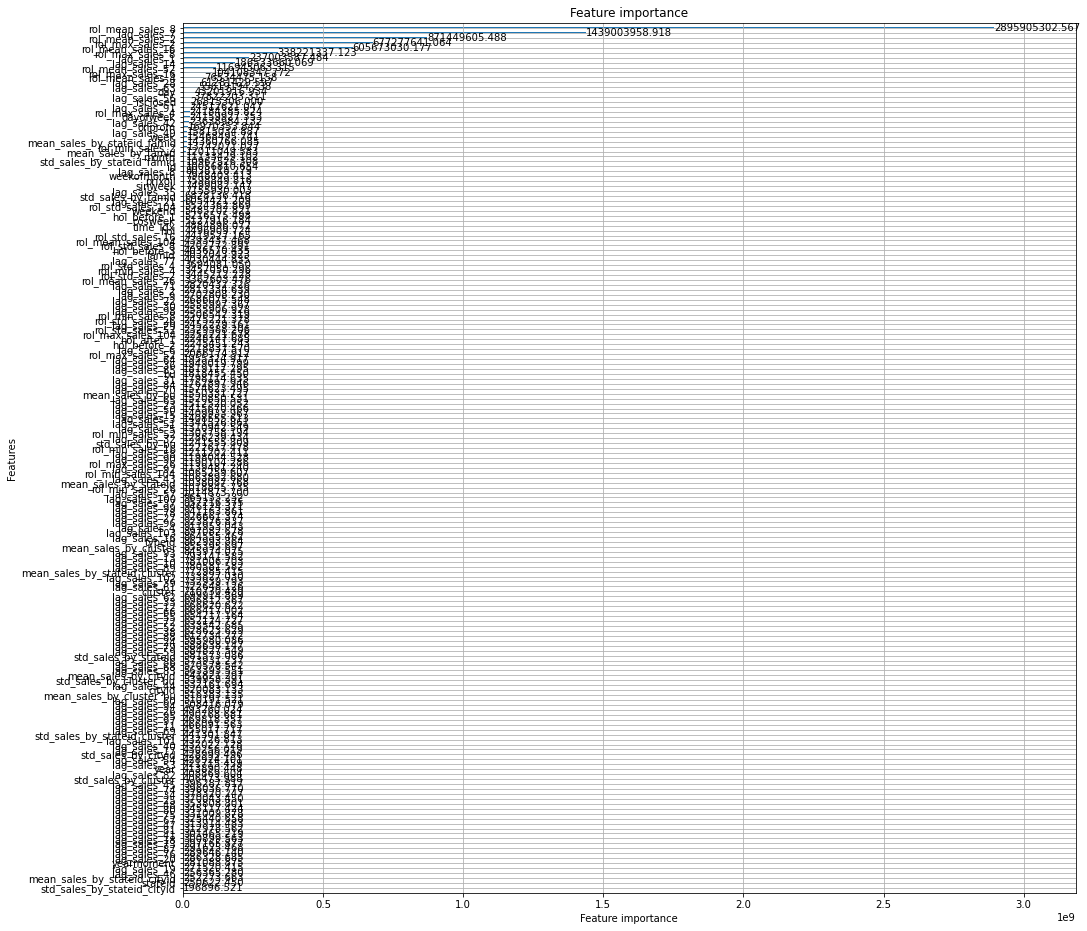

In [77]:
from lightgbm import plot_importance
plot_importance(gbm, importance_type="gain", figsize=(16,16))

In [10]:
prediction_length = 16
lags_target=list(range(1, 16))
rollings_target=[2, 4, 8, 16]


def calculate_lags(df, col, lags, shift=0):
    for l in lags:
        df[f"lag_{col}_{l}"] = df.groupby(["ts_id"])[col].shift(shift + l).astype(np.float16)

def calculate_rollings(df, col, rollings, shift=0):
    for r in rollings:
        df[f"rol_mean_{col}_{r}"] = df.groupby(["ts_id"])[col].shift(shift + 1).rolling(r, min_periods=1).mean()
        df[f"rol_std_{col}_{r}"] = df.groupby(["ts_id"])[col].shift(shift + 1).rolling(r, min_periods=1).std()
        df[f"rol_min_{col}_{r}"] = df.groupby(["ts_id"])[col].shift(shift + 1).rolling(r, min_periods=1).min()
        df[f"rol_max_{col}_{r}"] = df.groupby(["ts_id"])[col].shift(shift + 1).rolling(r, min_periods=1).max()


In [11]:
df_cutoff.loc[df_cutoff["is_future"] == True, "sales"] = np.nan

for fs in range(1, prediction_length + 1):
    print(fs)
    
    # predict one step
    df_predict = df_cutoff.loc[df_cutoff["forecast_step"] == fs].drop(columns=col_to_ignore + [TARGET_COL])
    predictions = np.clip(gbm.predict(df_predict), a_min=0, a_max=None)
    
    # update sales_quantity usings predictions
    df_cutoff.loc[df_cutoff["forecast_step"] == fs, "sales"] = predictions
    
    # update target lags & rollings
    calculate_lags(df_cutoff, TARGET_COL, lags_target)
    calculate_rollings(df_cutoff, TARGET_COL, rollings_target)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [12]:
df_forecast = df_cutoff.loc[df_cutoff["is_future"] == True, ["ts_id", "date", "sales"]]
df_forecast["forecast"] = df_forecast["sales"].round(0).astype(int)
df_forecast.drop(columns="sales", inplace=True)

In [13]:
clean = pd.read_csv(path + f'trainclean.csv', sep=';')
clean['date'] = pd.to_datetime(clean['date'])

In [14]:
df_error = pd.merge(df_forecast, clean[['ts_id', 'date', 'sales']], how="left", on=['ts_id', 'date'])
wape = np.round(np.sum(np.abs(df_error["sales"] - df_error["forecast"])) / np.sum(df_error["sales"]), 3)
wape

0.147

In [ ]:
{'num_leaves': 10,
 'learning_rate': 0.17381447305763387,
 'objective': 'tweedie',
 'min_child_samples': 80,
 'subsample': 0.9,
 'colsample_bytree': 0.6000000000000001,
 'reg_alpha': 1.0,
 'reg_lambda': 0.6000000000000001,
 'tweedie_variance_power': 1.1,
 'subsample_freq': 1}

In [15]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [16]:
x_train = df_cutoff.drop(columns=TARGET_COL)
x_train["time_idx"] = ((x_train["date"] - x_train["date"].min()).dt.days).astype(int)

In [20]:
for train_idx, test_idx in GroupTimeSeriesSplit().split(x_train, groups=x_train['time_idx']):
    print(x_train.loc[train_idx, 'time_idx'].unique())
    print(x_train.loc[test_idx, 'time_idx'].unique()[:16])
    break

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

In [19]:
1

1